In [1]:
import pickle
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas
from pathlib import Path
from ripe.atlas.cousteau import AtlasRequest
from collections import namedtuple
import csv
import pandas as pd

In [2]:
# Create Amsterdam areas GDF
df = geopandas.read_file("map-data/AMS_areas.csv")
df['Coordinates'] = geopandas.GeoSeries.from_wkt(df['WKT_LNG_LAT'])
df.head()

ams_areas_gdf = geopandas.GeoDataFrame(df, geometry='Coordinates')
ams_areas_gdf = ams_areas_gdf.set_crs("EPSG:4326")

print(ams_areas_gdf.columns)
ams_areas_gdf.head()

Index(['OBJECTNUMMER', 'Gebiedcode', 'Gebied', 'Stadsdeelcode', 'Stadsdeel',
       'Oppervlakte_m2', 'WKT_LNG_LAT', 'WKT_LAT_LNG', 'LNG', 'LAT',
       'field_11', 'geometry', 'Coordinates'],
      dtype='object')


,OBJECTNUMMER,Gebiedcode,Gebied,Stadsdeelcode,Stadsdeel,Oppervlakte_m2,WKT_LNG_LAT,WKT_LAT_LNG,LNG,LAT,field_11,geometry,Coordinates
0,1,GA01,Centrum-West,A,Centrum,3450130,"POLYGON((4.875487 52.37341,4.875432 52.373235,...","POLYGON((52.37341 4.875487,52.373235 4.875432,...",4.890425,52.3768085,,None,"POLYGON ((4.87549 52.37341, 4.87543 52.37324, ..."
1,2,GF08,Osdorp,F,Nieuw-West,9139771,"POLYGON((4.759085 52.380944,4.759092 52.380761...","POLYGON((52.380944 4.759085,52.380761 4.759092...",4.787641,52.363831,,None,"POLYGON ((4.75908 52.38094, 4.75909 52.38076, ..."
2,3,GA02,Centrum-Oost,A,Centrum,4562763,"POLYGON((4.879225 52.364925,4.879218 52.364778...","POLYGON((52.364925 4.879225,52.364778 4.879218...",4.9060955,52.368988,,None,"POLYGON ((4.87922 52.36492, 4.87922 52.36478, ..."
3,4,GE03,Westerpark,E,West,5048982,"POLYGON((4.844319 52.395304,4.844233 52.394945...","POLYGON((52.395304 4.844319,52.394945 4.844233...",4.8696,52.3854825,,None,"POLYGON ((4.84432 52.39530, 4.84423 52.39494, ..."
4,5,GE04,Bos en Lommer,E,West,2226099,"POLYGON((4.835337 52.373153,4.840604 52.37233,...","POLYGON((52.373153 4.835337,52.37233 4.840604,...",4.849888,52.378793,,None,"POLYGON ((4.83534 52.37315, 4.84060 52.37233, ..."


In [3]:
# Read anchor coordinates 
with open('pickle-files/anchor-coordinates.pickle', 'rb') as file_handle:
    anchor_coordinates = pickle.load(file_handle)
    
# Filter out anchors that are in AMS areas GDF only
anchors_gdf = geopandas.GeoDataFrame({
    "anchor_id": list(anchor_coordinates.keys()),
    "geometry": [
        Point(anchor_coordinates[key][0], anchor_coordinates[key][1]) for key in list(anchor_coordinates.keys())
    ]
}, crs='EPSG:4326')

result = geopandas.sjoin(anchors_gdf, ams_areas_gdf, how='left', predicate='within')
result = result[result['WKT_LNG_LAT'].notna()]

anchors_in_ams_df = result[['anchor_id', 'geometry_left']].copy()
anchors_in_ams_df = anchors_in_ams_df.rename({'pnt': 'probe_id', 'geometry_left': 'geometry'}, axis=1)

anchors_in_ams_gdf = geopandas.GeoDataFrame(anchors_in_ams_df)

print(anchors_in_ams_gdf)
print("Number of anchors in AMS acc. to RIPE Atlas = {}".format(len(anchor_coordinates.keys())))
print("Number of anchors in AMS after intersecting with polygons = {}".format(len(anchors_in_ams_gdf)))

anchor_ids_in_ams_map = list(anchors_in_ams_gdf["anchor_id"])

    anchor_id                  geometry
0         282  POINT (4.89517 52.37022)
1        2494  POINT (4.96131 52.35472)
2        2273  POINT (4.95088 52.35716)
3         670  POINT (4.91736 52.33288)
4         414  POINT (4.83243 52.34543)
6        2737  POINT (4.95916 52.35488)
8        2481  POINT (4.95916 52.35488)
9        1973  POINT (4.93189 52.33652)
10       1293  POINT (4.82924 52.34493)
14       1411  POINT (4.84921 52.39290)
15        954  POINT (4.89517 52.37022)
16       1922  POINT (4.94508 52.29341)
17        401  POINT (4.88648 52.33617)
18       2266  POINT (4.88668 52.33628)
19        269  POINT (4.93789 52.30299)
20       1135  POINT (4.89517 52.37022)
21       1304  POINT (4.89517 52.37022)
22         12  POINT (4.88824 52.37322)
23        632  POINT (4.88824 52.37322)
25       1819  POINT (4.90356 52.36798)
26        822  POINT (4.93189 52.33652)
27       3210  POINT (4.83147 52.34447)
28        422  POINT (4.83243 52.34543)
29       2834  POINT (4.94505 52.29335)


<AxesSubplot: >

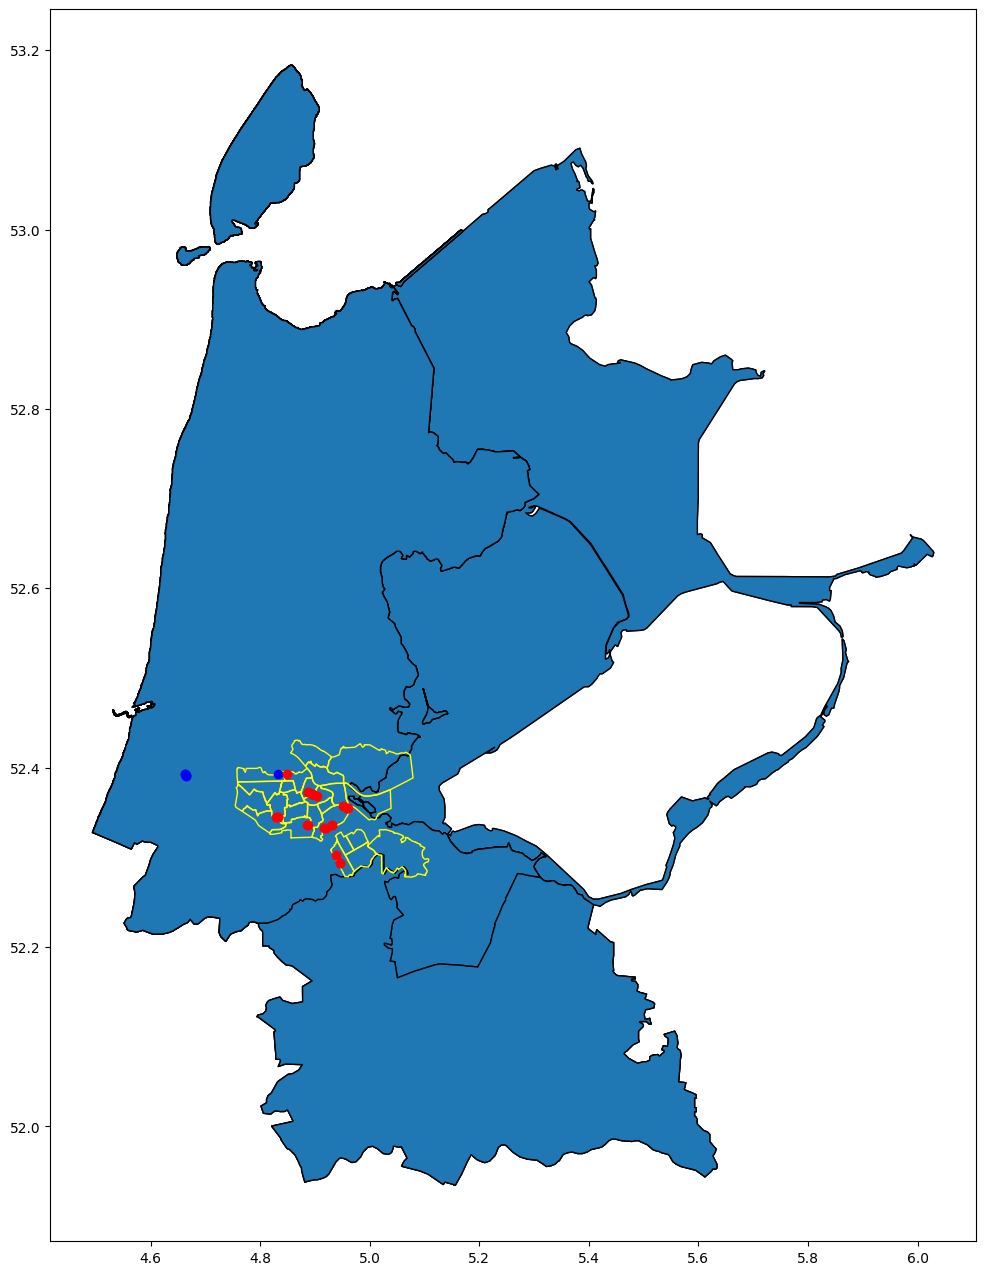

In [4]:
# Plot how anchors are located in regard to AMS gebieds

%matplotlib inline
    
anchors_gdf = geopandas.GeoDataFrame({
    "anchor_id": list(anchor_coordinates.keys()),
    "geometry": [
        Point(anchor_coordinates[key][0], anchor_coordinates[key][1]) for key in list(anchor_coordinates.keys())
    ]
}, crs='epsg:4326')

anchors_outside_ams_df = geopandas.sjoin(anchors_gdf, ams_areas_gdf, how='left', predicate='within')
anchors_outside_ams_df = anchors_outside_ams_df[anchors_outside_ams_df['WKT_LNG_LAT'].isna()]
anchors_outside_ams_df = anchors_outside_ams_df[['anchor_id', 'geometry_left']].copy()
anchors_outside_ams_df = anchors_outside_ams_df.rename({'geometry_left': 'geometry'}, axis=1)
anchors_outside_ams_df = geopandas.GeoDataFrame(anchors_outside_ams_df)

nl  = geopandas.read_file("nl_shape/NLD_adm1.shp")

combine_nl_and_ams = geopandas.sjoin(nl, ams_areas_gdf, how="inner", predicate="overlaps")
combine_nl_and_ams = combine_nl_and_ams[['geometry_left']].copy()
combine_nl_and_ams = combine_nl_and_ams.rename({'geometry_left': 'geometry'}, axis=1)
combine_nl_and_ams = geopandas.GeoDataFrame(combine_nl_and_ams)

# plot
fig1, ax = plt.subplots(figsize=(32, 16))
combine_nl_and_ams.plot(ax=ax, edgecolor='black')
ams_areas_gdf.plot(ax=ax, facecolor="none",
              edgecolor='yellow')
anchors_outside_ams_df.plot(ax=ax, color='blue')
anchors_in_ams_gdf.plot(ax=ax, color='red')

In [5]:
# Open a list of NL probes from original code saved to a file
with open('pickle-files/list_of_NL_probes_by_anchor_id_dump.pickle', 'rb') as file_handle:
    list_of_NL_probes_by_anchor_id = pickle.load(file_handle)

#Remove duplicate probe ids and don't include anchor ids with 0 probes
list_of_NL_probes_by_anchor_id_without_duplicates = {}
duplicates = {}

for anchor_id in list_of_NL_probes_by_anchor_id:
    probes = {}
    list_of_probes = list_of_NL_probes_by_anchor_id[anchor_id]
    if list_of_probes:
        list_of_NL_probes_by_anchor_id_without_duplicates[anchor_id] = []
        duplicates[anchor_id] = 0
        for probe_id in list_of_probes:
            if probes.get(probe_id):
                duplicates[anchor_id] += 1
                continue
            else:
                probes[probe_id] = True
                list_of_NL_probes_by_anchor_id_without_duplicates[anchor_id].append(probe_id)    

for anchor_id in list_of_NL_probes_by_anchor_id:
    if list_of_NL_probes_by_anchor_id_without_duplicates.get(anchor_id):
        print(f"Anchor {anchor_id} original probes: {len(list_of_NL_probes_by_anchor_id[anchor_id])}, duplicates: {duplicates[anchor_id]}, distinct: {len(list_of_NL_probes_by_anchor_id_without_duplicates[anchor_id])}")

Anchor 282 original probes: 48150, duplicates: 48063, distinct: 87
Anchor 954 original probes: 51755, duplicates: 51691, distinct: 64
Anchor 1135 original probes: 13406055, duplicates: 13405253, distinct: 802
Anchor 1304 original probes: 78798, duplicates: 78677, distinct: 121
Anchor 2494 original probes: 66193, duplicates: 66095, distinct: 98
Anchor 2273 original probes: 73392, duplicates: 73312, distinct: 80
Anchor 670 original probes: 73392, duplicates: 73312, distinct: 80
Anchor 2737 original probes: 92380, duplicates: 92276, distinct: 104
Anchor 2481 original probes: 68084, duplicates: 68003, distinct: 81
Anchor 1973 original probes: 67190, duplicates: 67097, distinct: 93
Anchor 2884 original probes: 62997, duplicates: 62908, distinct: 89
Anchor 414 original probes: 52976, duplicates: 52908, distinct: 68
Anchor 1293 original probes: 55148, duplicates: 55085, distinct: 63
Anchor 3210 original probes: 54540, duplicates: 54463, distinct: 77
Anchor 422 original probes: 57440, duplicat

In [6]:
#Create one list which combines probe ids without duplicates across anchors
duplicates_check = {}
list_of_NL_probes_without_duplicates = []

for anchor_id in list_of_NL_probes_by_anchor_id_without_duplicates:
    list_of_probes = list_of_NL_probes_by_anchor_id_without_duplicates[anchor_id]
    for probe_id in list_of_probes:
        if duplicates_check.get(probe_id):
            continue
        else:
            duplicates_check[probe_id] = True
            list_of_NL_probes_without_duplicates.append(probe_id) 

In [7]:
# Calculate on how many areas of AMS each anchors probes are located
with open('pickle-files/probe-coordinates.pickle', 'rb') as file_handle:
    probe_coordinates = pickle.load(file_handle)

ams_areas_covered_by_probes_of_each_anchor = {}

for anchor_id in list_of_NL_probes_by_anchor_id_without_duplicates:
    probes_by_anchor = list_of_NL_probes_by_anchor_id_without_duplicates[anchor_id]
    probes_gdf = geopandas.GeoDataFrame({
        "pnt": probes_by_anchor,
        "geometry": [
            Point(probe_coordinates[key][0], probe_coordinates[key][1]) for key in probes_by_anchor
        ]},
        crs='EPSG:4326'
    )

    result = geopandas.sjoin(probes_gdf, ams_areas_gdf, how='inner', predicate='within')
    ams_areas_covered_by_probes_of_each_anchor[anchor_id] = result.Gebied.value_counts().size

display(ams_areas_covered_by_probes_of_each_anchor)

{282: 10,
 954: 10,
 1135: 22,
 1304: 14,
 2494: 12,
 2273: 11,
 670: 11,
 2737: 11,
 2481: 11,
 1973: 10,
 2884: 14,
 414: 10,
 1293: 12,
 3210: 11,
 422: 11,
 1411: 9,
 1922: 11,
 2834: 11,
 401: 11,
 2266: 11,
 1819: 10}

In [8]:
# leave into list_of_NL_probes_by_anchor_id_without_duplicates only 
# the probes that match some AMS area

distinct_probe_ids_matching_AMS_area_by_anchor = {}

for anchor_id in list_of_NL_probes_by_anchor_id_without_duplicates:
    probes_by_anchor = list_of_NL_probes_by_anchor_id_without_duplicates[anchor_id]
    probes_gdf = geopandas.GeoDataFrame({
        "pnt": probes_by_anchor,
        "geometry": [
            Point(probe_coordinates[key][0], probe_coordinates[key][1]) for key in probes_by_anchor
        ]},
        crs='EPSG:4326'
    )

    result = geopandas.sjoin(probes_gdf, ams_areas_gdf, how='inner', predicate='within')
    distinct_probe_ids_matching_AMS_area_by_anchor[anchor_id] = result.pnt.tolist()

for key in distinct_probe_ids_matching_AMS_area_by_anchor:
    print(f"{key}: {len(distinct_probe_ids_matching_AMS_area_by_anchor[key])}")

282: 24
954: 20
1135: 161
1304: 33
2494: 29
2273: 25
670: 25
2737: 23
2481: 24
1973: 21
2884: 27
414: 19
1293: 21
3210: 24
422: 23
1411: 13
1922: 22
2834: 21
401: 25
2266: 25
1819: 26


In [9]:
# Open from file & try to find suitable measurements
with open('pickle-files/measurements_by_anchor_id_dump.pickle', 'rb') as file_handle:
    measurements_by_anchor_id = pickle.load(file_handle)

chosen_anchors_usecase = distinct_probe_ids_matching_AMS_area_by_anchor.keys()

chosen_first_measurements = {}
measurements_to_anchors_mapping = {}
single_measurement_available = []
for anchor_id in chosen_anchors_usecase:
    chosen_probes_usecase = distinct_probe_ids_matching_AMS_area_by_anchor[anchor_id]
    measurements_list = measurements_by_anchor_id[anchor_id]["results"]
    for measurement in measurements_list:
        list_of_probes = [item["id"] for item in measurement["probes"]]
        set_of_intersecting_probes = set(chosen_probes_usecase) & set(list_of_probes)
        if len(set_of_intersecting_probes) > 11:
            chosen_first_measurements[measurement['id']] = list(set_of_intersecting_probes)
            measurements_to_anchors_mapping[measurement['id']] = anchor_id
            single_measurement_available.append(anchor_id)
            print(anchor_id, measurement['id'])
            break
print(chosen_first_measurements)

282 1402318
954 7740606
1135 9333345
1304 11680334
2494 29724243
2273 29095964
670 29095964
2737 29560020
2481 27302234
1973 23217820
2884 32082351
414 1769336
1293 16453122
3210 45664346
422 1790204
1922 23062801
2834 31323747
401 29382782
2266 29382782
1819 22422574
{1402318: [6400, 6082, 6307, 6626, 6661, 7139, 6984, 6088, 6955, 6348, 6254, 6031, 7188, 6932, 7190, 6584, 6969], 7740606: [6400, 6082, 6307, 6626, 6661, 7139, 6984, 6088, 6955, 6348, 6220, 6254, 6031, 7188, 6932, 7190, 6584, 6969], 9333345: [6400, 6082, 6307, 6626, 6661, 7139, 6984, 6088, 6955, 6220, 6348, 6254, 6031, 7188, 6932, 7190, 6584, 6969], 11680334: [6400, 6661, 6031, 7188, 6932, 7190, 6307, 6955, 6584, 6969, 6082, 6984, 6088, 6348, 6220, 6626, 7139, 6254, 6399], 29724243: [6400, 6082, 6307, 6626, 6661, 7139, 6984, 6088, 6955, 6348, 6220, 6254, 6031, 6932, 7188, 7190, 6584, 6969], 29095964: [6400, 6082, 6307, 6626, 6661, 7139, 6984, 6088, 6955, 6348, 6220, 6254, 6031, 6932, 7188, 7190, 6584, 6969], 29560020: [64

In [10]:
# Map found measurement probes onto AMS map to see how they are located.
# Shows the anchor id and how many distinct areas are covered by the probes corresponding to a specific measurement of the anchor
with open('pickle-files/probe-coordinates.pickle', 'rb') as file_handle:
    probe_coordinates = pickle.load(file_handle)

number_of_areas_intersecting_probes_of_each_anchor_cover = {}

# save measurement id and a corresponding result for creating plots
results = []
measurements_as_list = []

for measurement_id in chosen_first_measurements:
    probes_by_measurement = chosen_first_measurements[measurement_id]
    probes_gdf = geopandas.GeoDataFrame({
        "pnt": probes_by_measurement,
        "geometry": [
            Point(probe_coordinates[key][0], probe_coordinates[key][1]) for key in probes_by_measurement
        ]},
        crs='EPSG:4326'
    )

    result = geopandas.sjoin(probes_gdf, ams_areas_gdf, how='inner', predicate='within')
    number_of_areas_intersecting_probes_of_each_anchor_cover[measurements_to_anchors_mapping[measurement_id]] = result.Gebied.value_counts().size

display(number_of_areas_intersecting_probes_of_each_anchor_cover)
display(f"Maximal area coverage for the set of anchors of size {len(number_of_areas_intersecting_probes_of_each_anchor_cover.keys())} is {min(number_of_areas_intersecting_probes_of_each_anchor_cover.values())} AMS areas.")

ten_and_more_areas = {anchor_id: number_of_areas_intersecting_probes_of_each_anchor_cover[anchor_id] for anchor_id in number_of_areas_intersecting_probes_of_each_anchor_cover if number_of_areas_intersecting_probes_of_each_anchor_cover[anchor_id] > 9}
display(ten_and_more_areas)

display(f"Maximal area coverage for the set of anchors of size {len(ten_and_more_areas.keys())} is 10 AMS areas.")

eleven_and_more_areas = {anchor_id: number_of_areas_intersecting_probes_of_each_anchor_cover[anchor_id] for anchor_id in number_of_areas_intersecting_probes_of_each_anchor_cover if number_of_areas_intersecting_probes_of_each_anchor_cover[anchor_id] > 10}
display(eleven_and_more_areas)

display(f"Maximal area coverage for the set of anchors of size {len(eleven_and_more_areas.keys())} is 11 AMS areas.")


{282: 9,
 954: 10,
 1135: 10,
 1304: 11,
 2494: 10,
 670: 10,
 2737: 10,
 2481: 10,
 1973: 10,
 2884: 10,
 414: 10,
 1293: 11,
 3210: 9,
 422: 10,
 1922: 10,
 2834: 9,
 2266: 10,
 1819: 10}

'Maximal area coverage for the set of anchors of size 18 is 9 AMS areas.'

{954: 10,
 1135: 10,
 1304: 11,
 2494: 10,
 670: 10,
 2737: 10,
 2481: 10,
 1973: 10,
 2884: 10,
 414: 10,
 1293: 11,
 422: 10,
 1922: 10,
 2266: 10,
 1819: 10}

'Maximal area coverage for the set of anchors of size 15 is 10 AMS areas.'

{1304: 11, 1293: 11}

'Maximal area coverage for the set of anchors of size 2 is 11 AMS areas.'

In [11]:
# Open from file & try to find suitable measurements
# UPDATE: collect all suitable measurements of a certain anchor instead of selecting just the first one
with open('pickle-files/measurements_by_anchor_id_dump.pickle', 'rb') as file_handle:
    measurements_by_anchor_id = pickle.load(file_handle)

chosen_anchors_usecase = distinct_probe_ids_matching_AMS_area_by_anchor.keys()

chosen_all_measurements = {}
measurements_to_anchors_mapping = {}
single_measurement_available = []
for anchor_id in chosen_anchors_usecase:
    chosen_probes_usecase = distinct_probe_ids_matching_AMS_area_by_anchor[anchor_id]
    measurements_list = measurements_by_anchor_id[anchor_id]["results"]
    for measurement in measurements_list:
        list_of_probes = [item["id"] for item in measurement["probes"]]
        set_of_intersecting_probes = set(chosen_probes_usecase) & set(list_of_probes)
        if len(set_of_intersecting_probes) > 11:
            chosen_all_measurements[measurement['id']] = list(set_of_intersecting_probes)
            measurements_to_anchors_mapping[measurement['id']] = anchor_id
            # add anchor with suitable measurement only once
            if anchor_id not in single_measurement_available:
                single_measurement_available.append(anchor_id)
            print(anchor_id, measurement['id'])
print(chosen_all_measurements)

282 1402318
954 7740606
1135 9333345
1135 42046355
1304 11680334
1304 11680344
2494 29724243
2494 29727765
2273 29095964
670 29095964
2737 29560020
2481 27302234
1973 23217820
2884 32082351
414 1769336
1293 16453122
3210 45664346
422 1790204
1922 23062801
2834 31323747
401 29382782
2266 29382782
1819 22422574
{1402318: [6400, 6082, 6307, 6626, 6661, 7139, 6984, 6088, 6955, 6348, 6254, 6031, 7188, 6932, 7190, 6584, 6969], 7740606: [6400, 6082, 6307, 6626, 6661, 7139, 6984, 6088, 6955, 6348, 6220, 6254, 6031, 7188, 6932, 7190, 6584, 6969], 9333345: [6400, 6082, 6307, 6626, 6661, 7139, 6984, 6088, 6955, 6220, 6348, 6254, 6031, 7188, 6932, 7190, 6584, 6969], 42046355: [1, 20482, 22019, 3, 6661, 6, 9, 17419, 15, 1005584, 51217, 18, 1004051, 7188, 7190, 26, 4636, 1002527, 3108, 37, 32808, 1005097, 42, 61992, 15919, 31288, 12857, 1000000, 1000513, 1000003, 61514, 1003088, 1004630, 61015, 1004631, 1004639, 1005152, 1002081, 6254, 1003634, 60019, 62068, 60037, 1000070, 60041, 10890, 1004174, 60

In [12]:
# CUSTOM: Map found measurement probes onto AMS map to see how they are located.
# Shows the anchor id and how many distinct areas are covered by the probes corresponding to a specific measurement of the anchor

# UPDATE: try to enhance the result produced by 1304, 1135 and 2494

with open('pickle-files/probe-coordinates.pickle', 'rb') as file_handle:
    probe_coordinates = pickle.load(file_handle)

number_of_areas_intersecting_probes_of_each_anchor_cover = {}

# save measurement id and a corresponding result for creating plots
# {"anchor_id": ["measurement_id", result]}
point_results = {}

for measurement_id in chosen_all_measurements:
    probes_by_measurement = chosen_all_measurements[measurement_id]
    probes_gdf = geopandas.GeoDataFrame({
        "pnt": probes_by_measurement,
        "geometry": [
            Point(probe_coordinates[key][0], probe_coordinates[key][1]) for key in probes_by_measurement
        ]},
        crs='EPSG:4326'
    )

    result = geopandas.sjoin(probes_gdf, ams_areas_gdf, how='inner', predicate='within')
    current_coverage = number_of_areas_intersecting_probes_of_each_anchor_cover.get(measurements_to_anchors_mapping[measurement_id])
    number_of_covered_ams_areas = result.Gebied.value_counts().size 
    
    if not current_coverage or current_coverage < number_of_covered_ams_areas:  
        number_of_areas_intersecting_probes_of_each_anchor_cover[measurements_to_anchors_mapping[measurement_id]] = number_of_covered_ams_areas
        # save only results with coverage at least 10 areas
        if number_of_covered_ams_areas > 9:
            point_results[measurements_to_anchors_mapping[measurement_id]] = [measurement_id, result]

display(number_of_areas_intersecting_probes_of_each_anchor_cover)
display(f"Maximal area coverage for the set of anchors of size {len(number_of_areas_intersecting_probes_of_each_anchor_cover.keys())} is {min(number_of_areas_intersecting_probes_of_each_anchor_cover.values())} AMS areas.")

ten_and_more_areas = {anchor_id: number_of_areas_intersecting_probes_of_each_anchor_cover[anchor_id] for anchor_id in number_of_areas_intersecting_probes_of_each_anchor_cover if number_of_areas_intersecting_probes_of_each_anchor_cover[anchor_id] > 9}
display(ten_and_more_areas)

display(f"Maximal area coverage for the set of anchors of size {len(ten_and_more_areas.keys())} is 10 AMS areas.")

eleven_and_more_areas = {anchor_id: number_of_areas_intersecting_probes_of_each_anchor_cover[anchor_id] for anchor_id in number_of_areas_intersecting_probes_of_each_anchor_cover if number_of_areas_intersecting_probes_of_each_anchor_cover[anchor_id] > 10}
display(eleven_and_more_areas)

display(f"Maximal area coverage for the set of anchors of size {len(eleven_and_more_areas.keys())} is 11 AMS areas.")

{282: 9,
 954: 10,
 1135: 21,
 1304: 11,
 2494: 10,
 670: 10,
 2737: 10,
 2481: 10,
 1973: 10,
 2884: 10,
 414: 10,
 1293: 11,
 3210: 9,
 422: 10,
 1922: 10,
 2834: 9,
 2266: 10,
 1819: 10}

'Maximal area coverage for the set of anchors of size 18 is 9 AMS areas.'

{954: 10,
 1135: 21,
 1304: 11,
 2494: 10,
 670: 10,
 2737: 10,
 2481: 10,
 1973: 10,
 2884: 10,
 414: 10,
 1293: 11,
 422: 10,
 1922: 10,
 2266: 10,
 1819: 10}

'Maximal area coverage for the set of anchors of size 15 is 10 AMS areas.'

{1135: 21, 1304: 11, 1293: 11}

'Maximal area coverage for the set of anchors of size 3 is 11 AMS areas.'

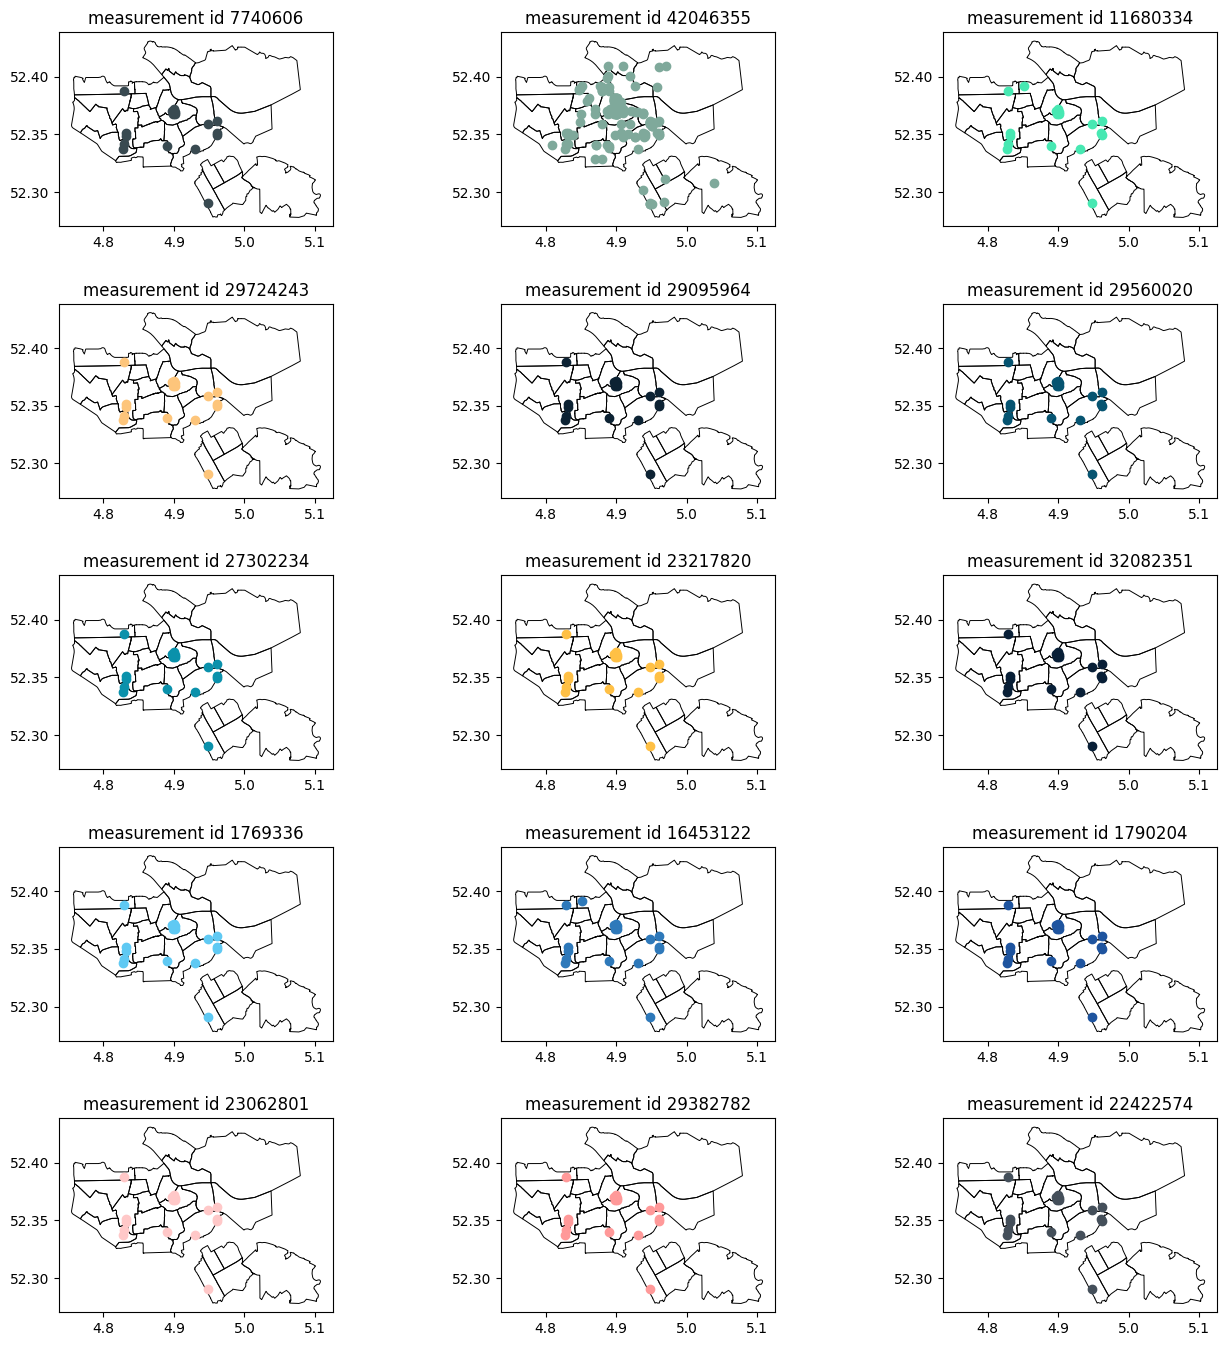

In [13]:
# Plot chosen mmeasurements onto Amsterdam gebieds

colors = ["#394a51", "#7fa99b", "#47e8b2", "#fdc57b", "#0c2233", "#065471", "#0a91ab", "#ffc045", "#081f37", "#5fc9f3", "#2e79ba", "#1e549f", "#ffc8c8", "#ff9999", "#444f5a"]

point_join_results = []
point_measurements_as_list = []

for anchor_id in point_results:
    point_measurements_as_list.append(point_results[anchor_id][0])
    point_join_results.append(point_results[anchor_id][1])

fig, ax = plt.subplots(5, 3, figsize=(24,16))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.6,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

index = 0
for i in range(5):
    for j in range(3):
        probes_in_ams_df = point_join_results[index].copy()
        probes_in_ams_df = probes_in_ams_df.rename({'pnt': 'probe_id', 'geometry_left': 'geometry'}, axis=1)

        probes_in_ams_gdf = geopandas.GeoDataFrame(probes_in_ams_df)
        ams_areas_gdf.plot(ax=ax[i][j], facecolor="none",
                edgecolor='black', lw=0.7)
        probes_in_ams_gdf.plot(ax=ax[i][j], color=colors[index])
        ax[i][j].set_title(f"measurement id {point_measurements_as_list[index]}")
        index += 1

In [14]:
# Match probes to areas and leave only areas maps

number_of_areas_intersecting_probes_of_each_anchor_cover = {}

# save measurement id and a corresponding result for creating plots
# {"anchor_id": ["measurement_id", result]}
area_results = {}

for measurement_id in chosen_all_measurements:
    probes_by_measurement = chosen_all_measurements[measurement_id]
    probes_gdf = geopandas.GeoDataFrame({
        "pnt": probes_by_measurement,
        "geometry": [
            Point(probe_coordinates[key][0], probe_coordinates[key][1]) for key in probes_by_measurement
        ]},
        crs='EPSG:4326'
    )

    result = geopandas.sjoin(ams_areas_gdf, probes_gdf, how='inner', predicate='contains')
    current_coverage = number_of_areas_intersecting_probes_of_each_anchor_cover.get(measurements_to_anchors_mapping[measurement_id])
    number_of_covered_ams_areas = result.Gebied.value_counts().size 
    
    if not current_coverage or current_coverage < number_of_covered_ams_areas:  
        number_of_areas_intersecting_probes_of_each_anchor_cover[measurements_to_anchors_mapping[measurement_id]] = number_of_covered_ams_areas
        # save only results with coverage at least 10 areas
        if number_of_covered_ams_areas > 9:
            area_results[measurements_to_anchors_mapping[measurement_id]] = [measurement_id, result]

display(len(area_results.keys()))

15

In [15]:
# Filter only the anchors that have measurements with coverage at least 10 areas
# Geometries from API call /api/v2/anchors/[anchor_id]

anchors_in_ams_gdf_coverage_at_least_10 = anchors_in_ams_gdf[anchors_in_ams_gdf["anchor_id"].isin(area_results.keys())].copy()
anchors_in_ams_gdf_coverage_at_least_10.to_crs(epsg=4326, inplace=True)
display(anchors_in_ams_gdf_coverage_at_least_10)

# Check that the filtered list has the same anchors as gave the result of mapping
display(set(anchors_in_ams_gdf_coverage_at_least_10["anchor_id"]) == set(ten_and_more_areas)) 

,anchor_id,geometry
1,2494,POINT (4.96131 52.35472)
3,670,POINT (4.91736 52.33288)
4,414,POINT (4.83243 52.34543)
6,2737,POINT (4.95916 52.35488)
8,2481,POINT (4.95916 52.35488)
9,1973,POINT (4.93189 52.33652)
10,1293,POINT (4.82924 52.34493)
15,954,POINT (4.89517 52.37022)
16,1922,POINT (4.94508 52.29341)
18,2266,POINT (4.88668 52.33628)


True

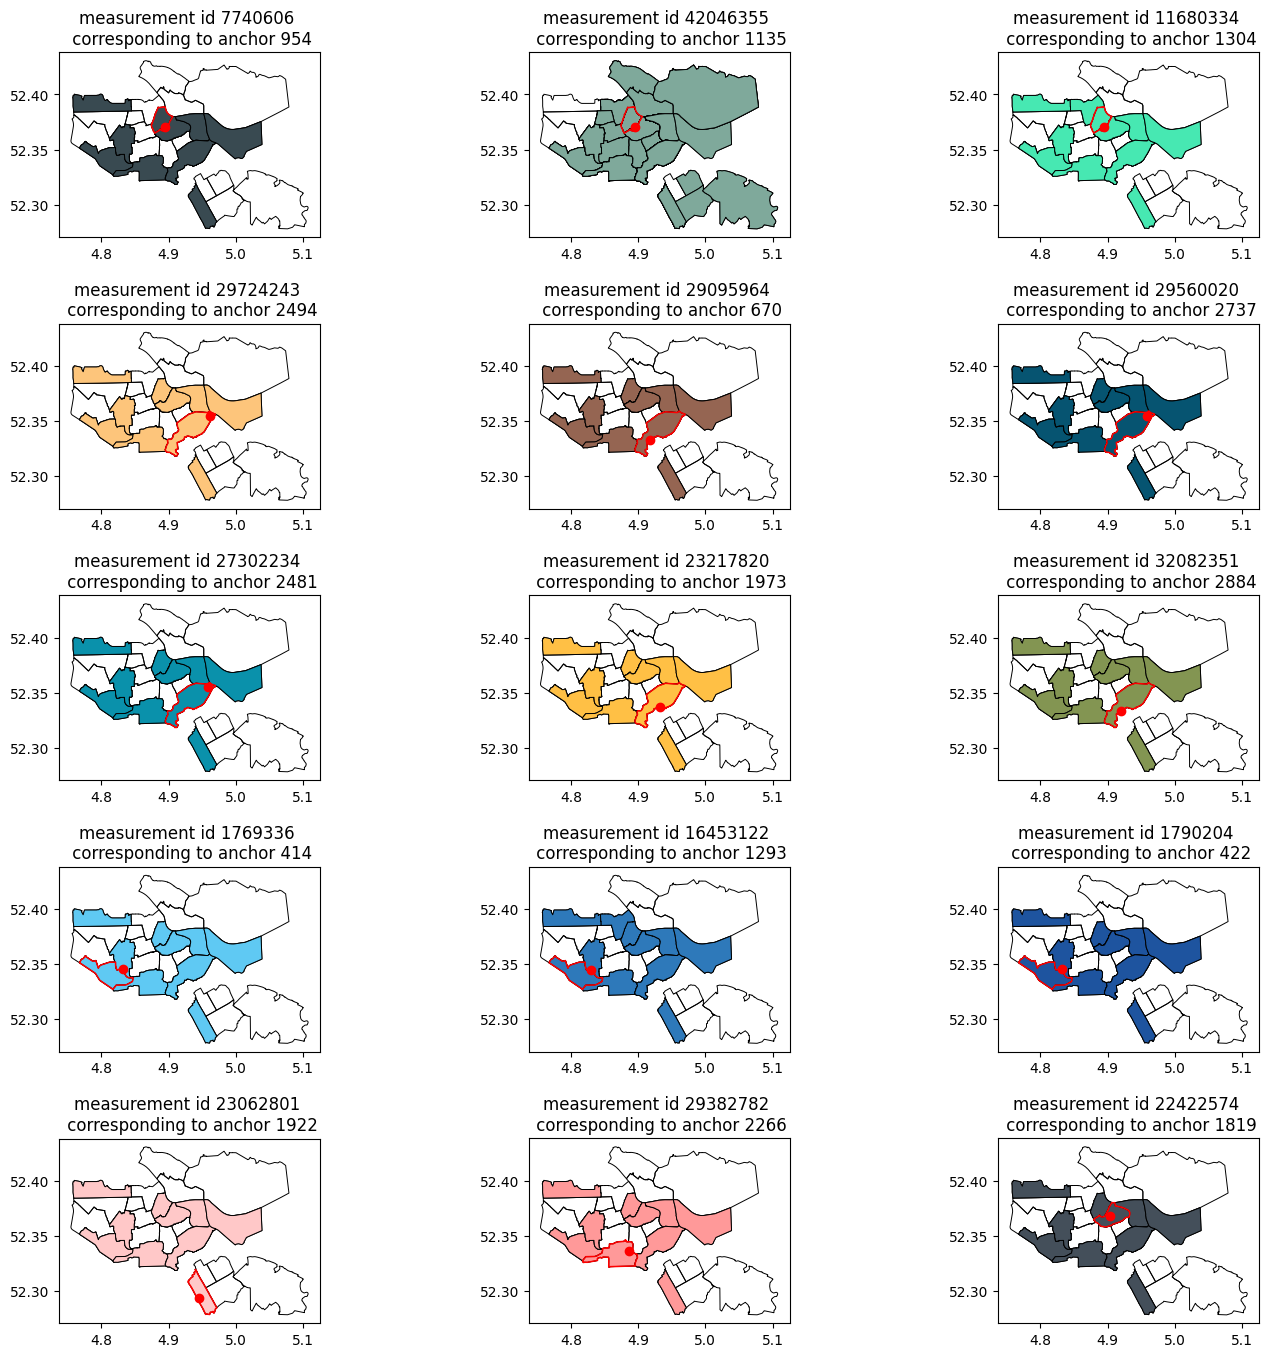

In [16]:
# Produce map of areas corresponding to anchors with coverage at least 10 gebieds
 
gebieds_corresponding_to_anchors_with_coverage_at_least_10 = geopandas.sjoin(ams_areas_gdf, anchors_in_ams_gdf_coverage_at_least_10, how='inner', predicate='contains')

# Plot how many gebieds are covered by a specific measurement probes
# Show anchor and gebied to which it belongs in red

colors = ["#394a51", "#7fa99b", "#47e8b2", "#fdc57b", "#956552", "#065471", "#0a91ab", "#ffc045", "#839552", "#5fc9f3", "#2e79ba", "#1e549f", "#ffc8c8", "#ff9999", "#444f5a"]

area_join_results = []
area_measurements_as_list = []
anchors = []

for anchor_id in area_results:
    area_measurements_as_list.append(area_results[anchor_id][0])
    area_join_results.append(area_results[anchor_id][1])
    anchors.append(anchor_id)


fig, ax = plt.subplots(5, 3, figsize=(24,16))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.6,
                    top=0.9,
                    wspace=0.8,
                    hspace=0.4)

index = 0
for i in range(5):
    for j in range(3):
        ams_areas_matching_probes_gdf = area_join_results[index].copy()
        ams_areas_gdf.plot(ax=ax[i][j], facecolor="none",
                edgecolor='black', lw=0.7)
        ams_areas_matching_probes_gdf.plot(ax=ax[i][j], edgecolor='black', lw=0.7, color=colors[index])
        anchors_in_ams_gdf_coverage_at_least_10[anchors_in_ams_gdf_coverage_at_least_10["anchor_id"] == anchors[index]].plot(ax=ax[i][j], color="red")
        gebieds_corresponding_to_anchors_with_coverage_at_least_10[gebieds_corresponding_to_anchors_with_coverage_at_least_10["anchor_id"] == anchors[index]].plot(ax=ax[i][j], facecolor="none", edgecolor='red', lw=1.1)
        ax[i][j].set_title(f"measurement id {area_measurements_as_list[index]} \n corresponding to anchor {anchors[index]}")
        index += 1

Measurement 42046355 gives better coverage for the anchor 1135, but it doesn't have 10 gebieds in common with other anchors since the area on the northern border is not represented in this measurement. It might be more beneficial to use the first found measurement for this anchor (9333345) with smaller area coverage, but with larger set of common areas with other anchors: 

In [17]:
# Save area results for first measurements with coverage at least 10 into a file

my_file = Path("pickle-files/area_results_for_first_measurements.pickle")
if not my_file.is_file():
    area_results_for_first_measurements = {}

    for measurement_id in chosen_first_measurements:
        probes_by_measurement = chosen_first_measurements[measurement_id]
        probes_gdf = geopandas.GeoDataFrame({
            "pnt": probes_by_measurement,
            "geometry": [
                Point(probe_coordinates[key][0], probe_coordinates[key][1]) for key in probes_by_measurement
            ]},
            crs='EPSG:4326'
        )

        result = geopandas.sjoin(ams_areas_gdf, probes_gdf, how='inner', predicate='contains')

        number_of_covered_ams_areas = result.Gebied.value_counts().size
        # save only results with coverage at least 10 areas
        if number_of_covered_ams_areas > 9:
            area_results_for_first_measurements[measurements_to_anchors_mapping[measurement_id]] = [measurement_id, result]
        
        with open('pickle-files/area_results_for_first_measurements.pickle', 'wb') as file_handle:
            pickle.dump(area_results_for_first_measurements, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('pickle-files/area_results_for_first_measurements.pickle', 'rb') as file_handle:
        area_results_for_first_measurements = pickle.load(file_handle)

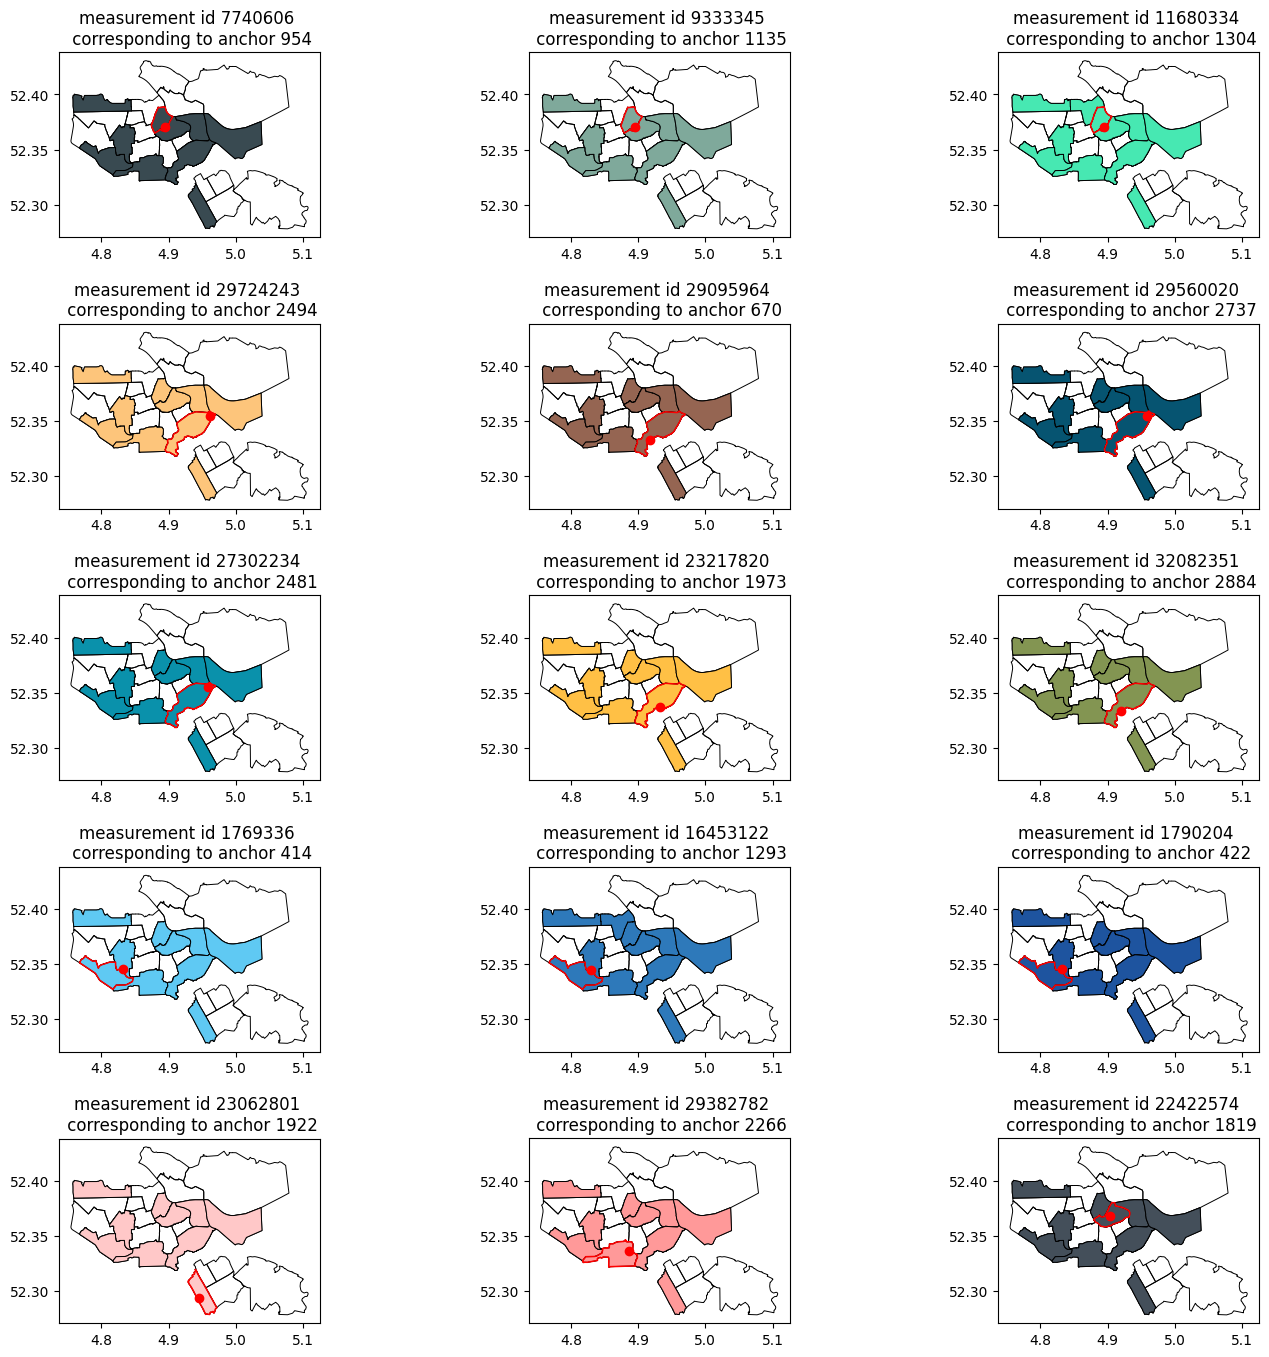

In [18]:
# Plot how many gebieds are covered by a specific measurement probes
# Show anchor and gebied to which it belongs in red

colors = ["#394a51", "#7fa99b", "#47e8b2", "#fdc57b", "#956552", "#065471", "#0a91ab", "#ffc045", "#839552", "#5fc9f3", "#2e79ba", "#1e549f", "#ffc8c8", "#ff9999", "#444f5a"]

area_first_join_results = []
area_first_measurements_as_list = []
anchors = []

for anchor_id in area_results_for_first_measurements:
    area_first_measurements_as_list.append(area_results_for_first_measurements[anchor_id][0])
    area_first_join_results.append(area_results_for_first_measurements[anchor_id][1])
    anchors.append(anchor_id)


fig, ax = plt.subplots(5, 3, figsize=(24,16))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.6,
                    top=0.9,
                    wspace=0.8,
                    hspace=0.4)

index = 0
for i in range(5):
    for j in range(3):
        ams_areas_matching_probes_gdf = area_first_join_results[index].copy()
        ams_areas_gdf.plot(ax=ax[i][j], facecolor="none",
                edgecolor='black', lw=0.7)
        ams_areas_matching_probes_gdf.plot(ax=ax[i][j], edgecolor='black', lw=0.7, color=colors[index])
        anchors_in_ams_gdf_coverage_at_least_10[anchors_in_ams_gdf_coverage_at_least_10["anchor_id"] == anchors[index]].plot(ax=ax[i][j], color="red")
        gebieds_corresponding_to_anchors_with_coverage_at_least_10[gebieds_corresponding_to_anchors_with_coverage_at_least_10["anchor_id"] == anchors[index]].plot(ax=ax[i][j], facecolor="none", edgecolor='red', lw=1.1)
        ax[i][j].set_title(f"measurement id {area_first_measurements_as_list[index]} \n corresponding to anchor {anchors[index]}")
        index += 1

In [19]:
def get_api(url_path):
    request = AtlasRequest(**{"url_path": url_path})
    result = namedtuple('Result', 'success response')
    (result.success, result.response) = request.get()
    if not result.success:
        print(result)
        return False

    return result.response

In [20]:
# Fetch selected anchors information and save to a file  

my_file = Path("pickle-files/anchors_with_coverage_10_or_more_areas.pickle")
if not my_file.is_file():
    anchors_with_coverage_10_or_more_areas = {}
    for anchor_id in list(area_results_for_first_measurements.keys()):
        api_response = get_api(f"/api/v2/anchors/{anchor_id}")
        anchors_with_coverage_10_or_more_areas[anchor_id] = api_response
    with open('pickle-files/anchors_with_coverage_10_or_more_areas.pickle', 'wb') as file_handle:
        pickle.dump(anchors_with_coverage_10_or_more_areas, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('pickle-files/anchors_with_coverage_10_or_more_areas.pickle', 'rb') as file_handle:
        anchors_with_coverage_10_or_more_areas = pickle.load(file_handle)

In [21]:
# Print the contents of anchors API response

anchor_id_to_probe_id = {}

print(f"anchor / probe id \t  IPv4 address \t \t  Netmask \t \t  Company")
for anchor in anchors_with_coverage_10_or_more_areas:
    anchor_id = anchors_with_coverage_10_or_more_areas[anchor]["id"]
    probe_id = anchors_with_coverage_10_or_more_areas[anchor]["probe"]
    ipv4 = anchors_with_coverage_10_or_more_areas[anchor]["ip_v4"]
    ipv4_netmask = anchors_with_coverage_10_or_more_areas[anchor]["ip_v4_netmask"]
    company = anchors_with_coverage_10_or_more_areas[anchor]["company"]
    anchor_id_to_probe_id[anchor_id] = probe_id
    if len(ipv4) < 15:
        ipv4 += " "*(15-len(ipv4))
    if ipv4_netmask is None:
        ipv4_netmask = "None"
        ipv4_netmask += " "*11
    print(f"{anchor_id} / {probe_id} \t\t  {ipv4} \t  {ipv4_netmask} \t  {company}")

anchor / probe id 	  IPv4 address 	 	  Netmask 	 	  Company
954 / 6254 		  194.122.76.250  	  255.255.255.252 	  GTT (AS286)
1135 / 6307 		  193.0.0.164     	  255.255.255.224 	  RIPE NCC
1304 / 6348 		  193.0.0.165     	  255.255.255.224 	  RIPE NCC
2494 / 6984 		  156.154.77.254  	  None            	  Neustar
670 / 6194 		  91.200.16.69    	  255.255.255.224 	  AMS-IX B.V.
2737 / 6969 		  188.166.44.91   	  None            	  DigitalOcean
2481 / 6870 		  46.183.250.14   	  None            	  BusinessConnect B.V.
1973 / 6661 		  92.38.184.82    	  None            	  G-Core Labs S.A.
2884 / 7031 		  45.150.40.189   	  None            	  BytePark
414 / 6082 		  199.10.66.231   	  255.255.255.240 	  Afilias AMS2
1293 / 6400 		  37.10.45.14     	  255.255.255.248 	  Booking.com
422 / 6088 		  5.57.17.65      	  255.255.255.248 	  Booking.com IT Services B.V.
1922 / 6626 		  84.38.236.1     	  255.255.255.192 	  Uniserver Internet BV
2266 / 6955 		  194.109.78.2    	  255.255.255.248 	  XS

In [22]:
# Fetch selected probes information and save to a file  

my_file = Path("pickle-files/probes_from_measurements_of_anchors_with_coverage_10_or_more_areas.pickle")
if not my_file.is_file():
    probes_from_measurements_of_anchors_with_coverage_10_or_more_areas = {}
    for measurement_id in area_first_measurements_as_list:
        for probe_id in chosen_first_measurements[measurement_id]:
            if not probes_from_measurements_of_anchors_with_coverage_10_or_more_areas.get(probe_id):
                api_response = get_api(f"/api/v2/probes/{probe_id}")
                probes_from_measurements_of_anchors_with_coverage_10_or_more_areas[probe_id] = api_response
    with open('pickle-files/probes_from_measurements_of_anchors_with_coverage_10_or_more_areas.pickle', 'wb') as file_handle:
        pickle.dump(probes_from_measurements_of_anchors_with_coverage_10_or_more_areas, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('pickle-files/probes_from_measurements_of_anchors_with_coverage_10_or_more_areas.pickle', 'rb') as file_handle:
        probes_from_measurements_of_anchors_with_coverage_10_or_more_areas = pickle.load(file_handle)

All probe API responses contain infomation about network prefix, but some anchor API responses miss netmask information. The option would be to fetch information about these anchors as probe API requests to get the prefix.

In [23]:
# Filter the list of probes to include only the probes from measurements with area coverage exactly 10 (exclude measurements 11680334 and 16453122)

my_file = Path("pickle-files/probes_from_measurements_of_anchors_with_coverage_exactly_10_areas.pickle")
if not my_file.is_file():
    measurements_as_list_coverage_exactly_10 = area_first_measurements_as_list.copy()
    measurements_as_list_coverage_exactly_10.remove(11680334)
    measurements_as_list_coverage_exactly_10.remove(16453122)

    probes_from_measurements_of_anchors_with_coverage_exactly_10_areas = {}
    for measurement_id in measurements_as_list_coverage_exactly_10:
        for probe_id in chosen_first_measurements[measurement_id]:
            if not probes_from_measurements_of_anchors_with_coverage_exactly_10_areas.get(probe_id):
                probe_information = probes_from_measurements_of_anchors_with_coverage_10_or_more_areas[probe_id]
                probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe_id] = probe_information
    with open('pickle-files/probes_from_measurements_of_anchors_with_coverage_exactly_10_areas.pickle', 'wb') as file_handle:
        pickle.dump(probes_from_measurements_of_anchors_with_coverage_exactly_10_areas, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('pickle-files/probes_from_measurements_of_anchors_with_coverage_exactly_10_areas.pickle', 'rb') as file_handle:
        probes_from_measurements_of_anchors_with_coverage_exactly_10_areas = pickle.load(file_handle)


In [24]:
# Check whether all anchors also present as probes in selected measurements 
display(all(probe_id in probes_from_measurements_of_anchors_with_coverage_exactly_10_areas for probe_id in anchor_id_to_probe_id.values()))
print("Probes: ")
print(f"{list(probes_from_measurements_of_anchors_with_coverage_exactly_10_areas.keys())} \n")
print("Probe ids corresponding to the selected anchors:")
print(f"{list(anchor_id_to_probe_id.values())} \n")
print("Anchors that are not present in the measurements probes:")
for probe_id in anchor_id_to_probe_id.values():
    if probe_id not in probes_from_measurements_of_anchors_with_coverage_exactly_10_areas:
        print(probe_id)

False

Probes: 
[6400, 6082, 6307, 6626, 6661, 7139, 6984, 6088, 6955, 6348, 6220, 6254, 6031, 7188, 6932, 7190, 6584, 6969] 

Probe ids corresponding to the selected anchors:
[6254, 6307, 6348, 6984, 6194, 6969, 6870, 6661, 7031, 6082, 6400, 6088, 6626, 6955, 6584] 

Anchors that are not present in the measurements probes:
6194
6870
7031


In [25]:
# Print the contents of probes API response

for probe in probes_from_measurements_of_anchors_with_coverage_exactly_10_areas:
    probe_id = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["id"]
    ipv4 = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["address_v4"]
    prefix = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["prefix_v4"]
    is_anchor = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["is_anchor"]
    print(f"probe {probe_id}: {ipv4}, prefix: {prefix}, is anchor: {is_anchor}")

probe 6400: 37.10.45.14, prefix: 37.10.45.0/24, is anchor: True
probe 6082: 199.10.66.231, prefix: 199.10.66.0/24, is anchor: True
probe 6307: 193.0.0.164, prefix: 193.0.0.0/21, is anchor: True
probe 6626: 84.38.236.1, prefix: 84.38.224.0/20, is anchor: True
probe 6661: 92.38.184.82, prefix: 92.38.184.0/24, is anchor: True
probe 7139: 94.228.136.23, prefix: 94.228.136.0/21, is anchor: True
probe 6984: 156.154.77.254, prefix: 156.154.77.0/24, is anchor: True
probe 6088: 5.57.17.65, prefix: 5.57.17.0/24, is anchor: True
probe 6955: 194.109.78.2, prefix: 194.109.0.0/16, is anchor: True
probe 6348: 193.0.0.165, prefix: 193.0.0.0/21, is anchor: True
probe 6220: 217.196.33.252, prefix: 217.196.32.0/20, is anchor: True
probe 6254: 194.122.76.250, prefix: 194.122.76.0/22, is anchor: True
probe 6031: 145.220.0.55, prefix: 145.220.0.0/16, is anchor: True
probe 7188: 84.32.189.210, prefix: 84.32.188.0/22, is anchor: True
probe 6932: 91.200.16.69, prefix: 91.200.16.0/22, is anchor: True
probe 7190

In [26]:
#Fetch missing anchor (probe) information and save to a file  

my_file = Path("pickle-files/probe_information_for_anchors_missing_netmask.pickle")
# {"anchor_id": response object with the correspoding probe information}
probe_information_for_anchors_missing_netmask = {}

if not my_file.is_file():
    anchors_missing_netmask = [[anchors_with_coverage_10_or_more_areas[anchor]["id"], anchors_with_coverage_10_or_more_areas[anchor]["probe"]] for anchor in anchors_with_coverage_10_or_more_areas if anchors_with_coverage_10_or_more_areas[anchor]["prefix"] is None]
    for indexes in anchors_missing_netmask:
        # first index - anchor_id, second - probe_id
        api_response = get_api(f"/api/v2/probes/{indexes[1]}")
        probe_information_for_anchors_missing_netmask[indexes[0]] = api_response
    with open('pickle-files/probe_information_for_anchors_missing_netmask.pickle', 'wb') as file_handle:
        pickle.dump(probe_information_for_anchors_missing_netmask, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('pickle-files/probe_information_for_anchors_missing_netmask.pickle', 'rb') as file_handle:
        probe_information_for_anchors_missing_netmask = pickle.load(file_handle)

In [27]:
# Update anchors API response with prefix information

for anchor in anchors_with_coverage_10_or_more_areas:
    probe_id = anchors_with_coverage_10_or_more_areas[anchor]["probe"]
    if probe_id in probes_from_measurements_of_anchors_with_coverage_exactly_10_areas:
        anchors_with_coverage_10_or_more_areas[anchor]["prefix"] = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe_id]["prefix_v4"]
    else:
        anchors_with_coverage_10_or_more_areas[anchor]["prefix"] =  probe_information_for_anchors_missing_netmask[anchor]["prefix_v4"]

print(f"anchor / probe id \t  IPv4 address \t \t  Netmask \t \t  Company \t \t \t Prefix")
for anchor in anchors_with_coverage_10_or_more_areas:
    anchor_id = anchors_with_coverage_10_or_more_areas[anchor]["id"]
    probe_id = anchors_with_coverage_10_or_more_areas[anchor]["probe"]
    ipv4 = anchors_with_coverage_10_or_more_areas[anchor]["ip_v4"]
    ipv4_netmask = anchors_with_coverage_10_or_more_areas[anchor]["ip_v4_netmask"]
    company = anchors_with_coverage_10_or_more_areas[anchor]["company"]
    prefix = anchors_with_coverage_10_or_more_areas[anchor]["prefix"]
    anchor_id_to_probe_id[anchor_id] = probe_id
    if len(ipv4) < 15:
        ipv4 += " "*(15-len(ipv4))
    if ipv4_netmask is None:
        ipv4_netmask = "None"
        ipv4_netmask += " "*11
    if len(company) < 28:
        company += " "*(28-len(company))
    print(f"{anchor_id} / {probe_id} \t\t  {ipv4} \t  {ipv4_netmask} \t  {company} \t {prefix}")

anchor / probe id 	  IPv4 address 	 	  Netmask 	 	  Company 	 	 	 Prefix
954 / 6254 		  194.122.76.250  	  255.255.255.252 	  GTT (AS286)                  	 194.122.76.0/22
1135 / 6307 		  193.0.0.164     	  255.255.255.224 	  RIPE NCC                     	 193.0.0.0/21
1304 / 6348 		  193.0.0.165     	  255.255.255.224 	  RIPE NCC                     	 193.0.0.0/21
2494 / 6984 		  156.154.77.254  	  None            	  Neustar                      	 156.154.77.0/24
670 / 6194 		  91.200.16.69    	  255.255.255.224 	  AMS-IX B.V.                  	 91.200.16.0/22
2737 / 6969 		  188.166.44.91   	  None            	  DigitalOcean                 	 188.166.0.0/18
2481 / 6870 		  46.183.250.14   	  None            	  BusinessConnect B.V.         	 46.183.248.0/21
1973 / 6661 		  92.38.184.82    	  None            	  G-Core Labs S.A.             	 92.38.184.0/24
2884 / 7031 		  45.150.40.189   	  None            	  BytePark                     	 45.150.40.0/24
414 / 6082 		  199.10.66.231  

There is no anchor information associated with the probe in probe API response and anchor queries do not support parameter `probe_id`, so the only option to map probes to anchors was to search from the dict of all anchors in Amsterdam.  

In [28]:
# Open AMS anchor API response from python file

from anchors_dict_dump import anchors_dict

In [29]:
# Find anchors objects corresponding to probes (anchors_dict has only 35 items)
# Update probes API response to include company name 

for probe_id in probes_from_measurements_of_anchors_with_coverage_exactly_10_areas: 
    for anchor_id in anchors_dict:
        if anchors_dict[anchor_id]["probe"] == probe_id:
            probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe_id]["company"] = anchors_dict[anchor_id]["company"]
            probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe_id]["anchor_id"] = anchor_id
            probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe_id]["anchor_ipv4"] = anchors_dict[anchor_id]["ip_v4"]

In [30]:
# Update probes API response to include gebied name and objectnummer
# Use measurement 11680334 for probe gebied information

for probe_id in probes_from_measurements_of_anchors_with_coverage_exactly_10_areas: 
    row_corresponding_to_probe = point_join_results[2][point_join_results[2].pnt == probe_id]
    if row_corresponding_to_probe.values.size > 0:
        probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe_id]["gebied"] = row_corresponding_to_probe.Gebied.values[0]
        probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe_id]["objectnummer"] = row_corresponding_to_probe.OBJECTNUMMER.values[0]
    else:
        probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe_id]["gebied"] = None
        probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe_id]["objectnummer"] = None

In [31]:
# Save chosen probe (anchor) information into a csv file 

with open("probes_with_ips_and_gebieds.csv", mode="w") as f:
    fieldnames = ["anchor","probe id","Probe IPv4 address", "Anchor IPv4 address", "Company","Prefix","Also anchor","Objectnummer","Gebied"]
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for probe in probes_from_measurements_of_anchors_with_coverage_exactly_10_areas:
        anchor_id = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["anchor_id"]
        probe_id = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["id"]
        probe_ipv4 = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["address_v4"]
        anchor_ipv4 = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["anchor_ipv4"]
        prefix = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["prefix_v4"]
        company = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["company"]
        gebied = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["gebied"]
        objectnummer = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[probe]["objectnummer"]
        used_as_anchor = anchor_id in anchors_with_coverage_10_or_more_areas

        writer.writerow({"anchor": anchor_id, "probe id": probe_id, "Probe IPv4 address": probe_ipv4, "Anchor IPv4 address": anchor_ipv4, "Company": company, "Prefix": prefix, "Also anchor": used_as_anchor, "Objectnummer": objectnummer, "Gebied": gebied})

In [32]:
"""
Print the contents of probes API response

The table contains the list of disctinct probes used in measurements. If 'Also anchor' is True, then the probe is also used as an anchor, i.e. as the measurement endpoint.
If 'Also anchor' is False, then the probe is used in measurements purely as a traffic sending device. 
"""

probes_with_ips_and_gebieds = pd.read_csv("probes_with_ips_and_gebieds.csv")
display(probes_with_ips_and_gebieds)

,anchor,probe id,Probe IPv4 address,Anchor IPv4 address,Company,Prefix,Also anchor,Objectnummer,Gebied
0,1293,6400,37.10.45.14,37.10.45.14,Booking.com,37.10.45.0/24,True,9,"De Aker, Sloten, Nieuw-Sloten"
1,414,6082,199.10.66.231,199.10.66.231,Afilias AMS2,199.10.66.0/24,True,10,Slotervaart
2,1135,6307,193.0.0.164,193.0.0.164,RIPE NCC,193.0.0.0/21,True,1,Centrum-West
3,1922,6626,84.38.236.1,84.38.236.1,Uniserver Internet BV,84.38.224.0/20,True,21,Bijlmer-West
4,1973,6661,92.38.184.82,92.38.184.82,G-Core Labs S.A.,92.38.184.0/24,True,17,Watergraafsmeer
5,3210,7139,94.228.136.23,94.228.136.23,Prolocation B.V.,94.228.136.0/21,False,9,"De Aker, Sloten, Nieuw-Sloten"
6,2494,6984,156.154.77.254,156.154.77.254,Neustar,156.154.77.0/24,True,17,Watergraafsmeer
7,422,6088,5.57.17.65,5.57.17.65,Booking.com IT Services B.V.,5.57.17.0/24,True,10,Slotervaart
8,2266,6955,194.109.78.2,194.109.78.2,XS4ALL,194.109.0.0/16,True,12,"Buitenveldert, Zuidas"
9,1304,6348,193.0.0.165,193.0.0.165,RIPE NCC,193.0.0.0/21,True,3,Centrum-Oost


The anchor 414 is classified to De Aker, Sloten, Nieuw-Sloten gebied based on the anchor geometry retrieved from anchor API call (/api/v2/anchors/414): [4.832429, 52.345433]. This classification is present in the map with anchors produced previously. The probe 6082 is classified to Slotervaart gebied based on the probe geometry retrieved from anchor API call (/api/v2/probes/6082): [4.8315, 52.3485]. This classification is present in the above table. 

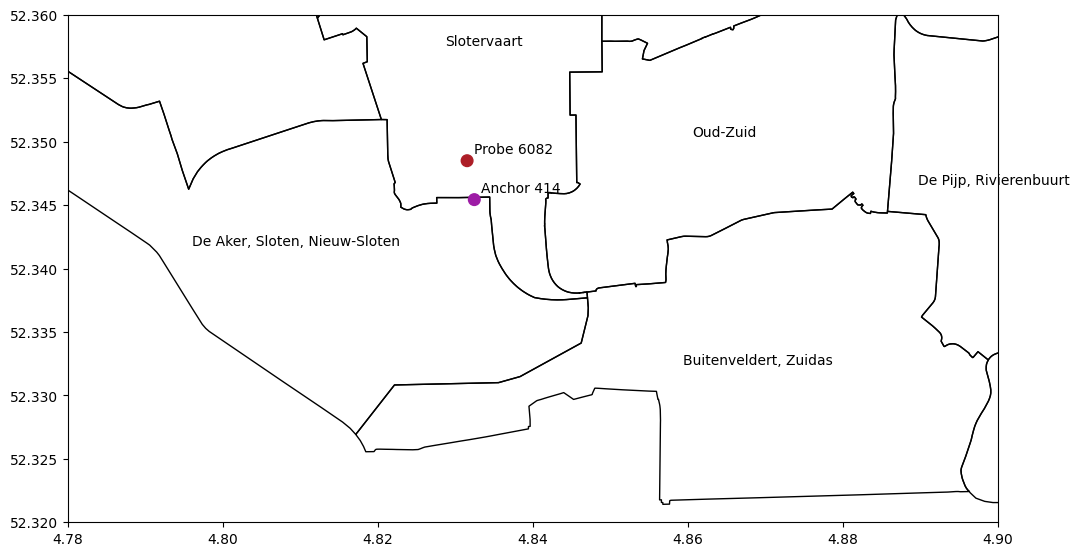

In [33]:
# Plot anchor 414 and the probe 6082 which represent the same device

%matplotlib inline

anchor_414_coordinates = anchors_with_coverage_10_or_more_areas[414]["geometry"]["coordinates"]
anchor_414_point = Point(anchor_414_coordinates[0], anchor_414_coordinates[1])

probe_6082_coordiantes = probes_from_measurements_of_anchors_with_coverage_exactly_10_areas[6082]["geometry"]["coordinates"]
probe_6082_point = Point(probe_6082_coordiantes[0], probe_6082_coordiantes[1])


anchor_414_probe_6082_gdf = geopandas.GeoDataFrame({
        "pnt": [414, 6082],
        "geometry": [anchor_414_point, probe_6082_point],
        "color": ["#9d1ca5", "#ad1e27"]},
        crs='EPSG:4326'
    )

fig, ax = plt.subplots(figsize=(12, 8))
ams_areas_gdf.plot(ax=ax, facecolor="none",
              edgecolor="black")
anchor_414_probe_6082_gdf.plot(ax=ax, markersize=70, color=anchor_414_probe_6082_gdf["color"])

ax.set_xlim(4.78, 4.90)
ax.set_ylim(52.32, 52.36)

for x, y, label in zip([anchor_414_coordinates[0], probe_6082_coordiantes[0]], [anchor_414_coordinates[1], probe_6082_coordiantes[1]], ["Anchor 414", "Probe 6082"]):
    ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points")

for idx, row in ams_areas_gdf.iterrows():   
    plt.annotate(text=row["Gebied"], xy=(row["Coordinates"].centroid.x, row["Coordinates"].centroid.y), horizontalalignment="center")

In [34]:
# Select probes that are common for all measurements
common_probes_to_all_chosen_measurements = set(chosen_first_measurements[9333345])
for measurement_id in [29724243, 16453122, 23062801, 22422574]:
    common_probes_to_all_chosen_measurements = set(common_probes_to_all_chosen_measurements) & set(chosen_first_measurements[measurement_id])

print("Probes that are common to the measurements of 5 chosen anchors:")
display(probes_with_ips_and_gebieds[probes_with_ips_and_gebieds["probe id"].isin(common_probes_to_all_chosen_measurements)])

print("Gebieds covered by the common probes:")
gebieds_covered_by_common_probes = probes_with_ips_and_gebieds[probes_with_ips_and_gebieds["probe id"].isin(common_probes_to_all_chosen_measurements)]["Objectnummer"].value_counts().reset_index()
gebieds_covered_by_common_probes.columns = ["Objectnummer", "counts"]
display(gebieds_covered_by_common_probes["Objectnummer"].values)
print("Number of gebieds covered by common probes:")
display(gebieds_covered_by_common_probes["Objectnummer"].values.size)
print("Probe that is not present in common probes:")
display(probes_with_ips_and_gebieds[~probes_with_ips_and_gebieds["probe id"].isin(common_probes_to_all_chosen_measurements)])

Probes that are common to the measurements of 5 chosen anchors:


,anchor,probe id,Probe IPv4 address,Anchor IPv4 address,Company,Prefix,Also anchor,Objectnummer,Gebied
0,1293,6400,37.10.45.14,37.10.45.14,Booking.com,37.10.45.0/24,True,9,"De Aker, Sloten, Nieuw-Sloten"
1,414,6082,199.10.66.231,199.10.66.231,Afilias AMS2,199.10.66.0/24,True,10,Slotervaart
2,1135,6307,193.0.0.164,193.0.0.164,RIPE NCC,193.0.0.0/21,True,1,Centrum-West
3,1922,6626,84.38.236.1,84.38.236.1,Uniserver Internet BV,84.38.224.0/20,True,21,Bijlmer-West
4,1973,6661,92.38.184.82,92.38.184.82,G-Core Labs S.A.,92.38.184.0/24,True,17,Watergraafsmeer
5,3210,7139,94.228.136.23,94.228.136.23,Prolocation B.V.,94.228.136.0/21,False,9,"De Aker, Sloten, Nieuw-Sloten"
6,2494,6984,156.154.77.254,156.154.77.254,Neustar,156.154.77.0/24,True,17,Watergraafsmeer
7,422,6088,5.57.17.65,5.57.17.65,Booking.com IT Services B.V.,5.57.17.0/24,True,10,Slotervaart
8,2266,6955,194.109.78.2,194.109.78.2,XS4ALL,194.109.0.0/16,True,12,"Buitenveldert, Zuidas"
9,1304,6348,193.0.0.165,193.0.0.165,RIPE NCC,193.0.0.0/21,True,3,Centrum-Oost


Gebieds covered by the common probes:


array([ 3, 17,  9, 10,  1, 21, 12,  7, 18, 16])

Number of gebieds covered by common probes:


10

Probe that is not present in common probes:


,anchor,probe id,Probe IPv4 address,Anchor IPv4 address,Company,Prefix,Also anchor,Objectnummer,Gebied


In [35]:
# Use probe geometries for chosen anchors
# Geometries from API call /api/v2/probes/[probe_id]

chosen_anchors = [1135, 1819, 1293, 2494, 1922]
chosen_anchors_with_their_probe_ids = {1135:6307, 1819:6584, 1293:6400, 2494:6984, 1922:6626}
points = []

for anchor_id in chosen_anchors:
    points.append(Point(probe_coordinates[chosen_anchors_with_their_probe_ids[anchor_id]][0], probe_coordinates[chosen_anchors_with_their_probe_ids[anchor_id]][1]))


chosen_anchors_in_ams_gdf = geopandas.GeoDataFrame({
    "anchor_id": chosen_anchors,
    "geometry": points
}, crs='EPSG:4326')

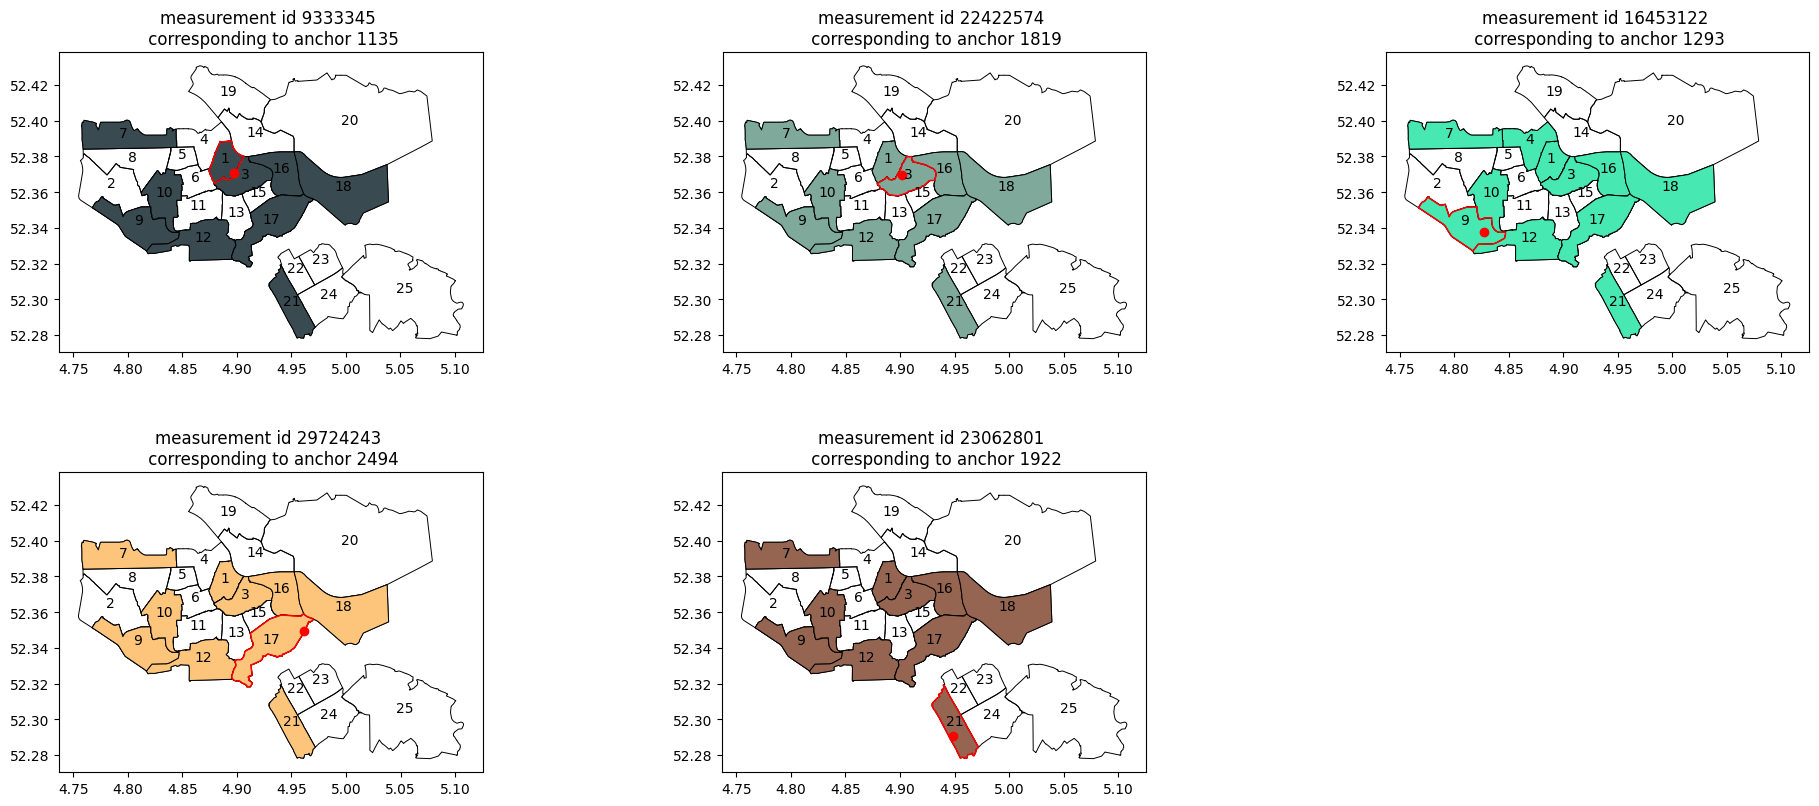

In [36]:
# Open saved results which use only the first found measurements
with open('pickle-files/area_results_for_first_measurements.pickle', 'rb') as file_handle:
    results_for_first_measurements = pickle.load(file_handle)

# Plot how many gebieds are covered by a specific measurement probes
# Show anchor and gebied to which it belongs in red

colors = ["#394a51", "#7fa99b", "#47e8b2", "#fdc57b", "#956552", "#065471", "#0a91ab", "#ffc045", "#839552", "#5fc9f3", "#2e79ba", "#1e549f", "#ffc8c8", "#ff9999", "#444f5a"]

area_first_join_results_selected_anchors = []
area_first_measurements_as_list_selected_anchors = []
anchors = []

for anchor_id in chosen_anchors:
    area_first_measurements_as_list_selected_anchors.append(results_for_first_measurements[anchor_id][0])
    area_first_join_results_selected_anchors.append(results_for_first_measurements[anchor_id][1])
    anchors.append(anchor_id)


fig, ax = plt.subplots(2, 3, figsize=(36,18))

plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.6,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

fig.delaxes(ax[1, 2])

index = 0
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            break
        ams_areas_matching_probes_gdf = area_first_join_results_selected_anchors[index].copy()
        ams_areas_gdf.plot(ax=ax[i][j], facecolor="none",
                edgecolor='black', lw=0.7)
        ams_areas_matching_probes_gdf.plot(ax=ax[i][j], edgecolor='black', lw=0.7, color=colors[index])   
        chosen_anchors_in_ams_gdf[chosen_anchors_in_ams_gdf["anchor_id"] == anchors[index]].plot(ax=ax[i][j], color="red")
        gebieds_corresponding_to_anchors_with_coverage_at_least_10[gebieds_corresponding_to_anchors_with_coverage_at_least_10["anchor_id"] == anchors[index]].plot(ax=ax[i][j], facecolor="none", edgecolor='red', lw=1.1)
        ax[i][j].set_title(f"measurement id {area_first_measurements_as_list_selected_anchors[index]} \n corresponding to anchor {anchors[index]}")
        index += 1

        for idx, row in ams_areas_gdf.iterrows():   
            ax[i][j].annotate(text=row["OBJECTNUMMER"], xy=(row["Coordinates"].centroid.x, row["Coordinates"].centroid.y), horizontalalignment="center")

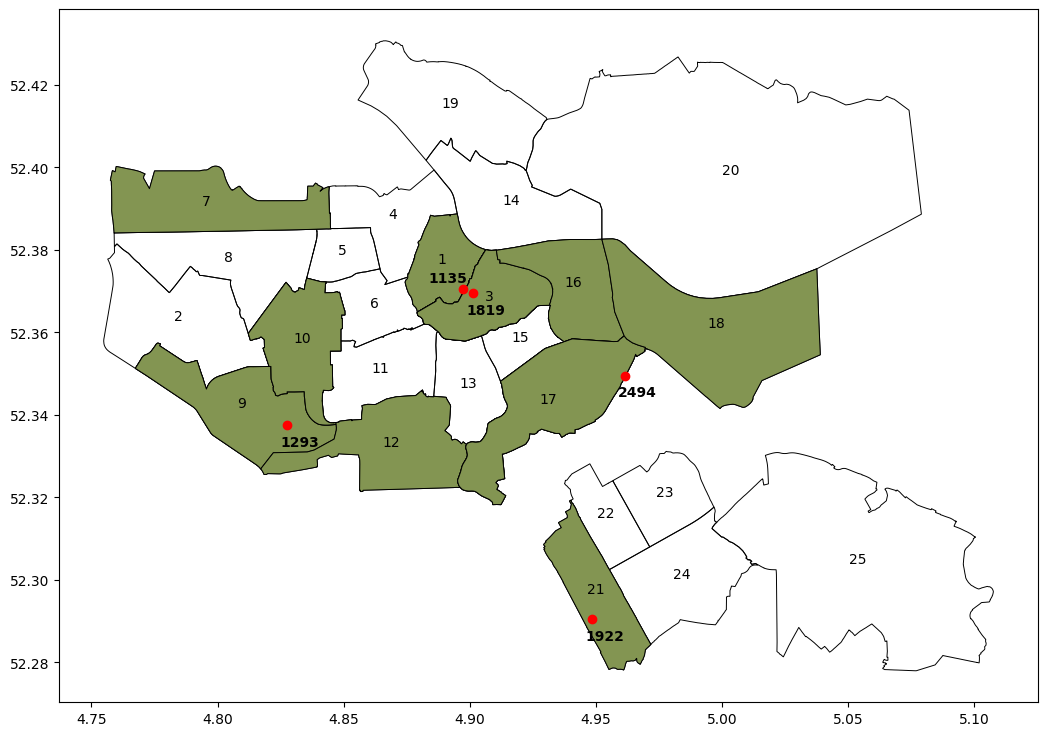

In [75]:
# Plot all chosen anchors with area coverage on the same plot 
# Use results for anchor 1135 as basis (all anchors currently cover the same 10 areas)

import numpy as np

fig, ax = plt.subplots(figsize=(24,9))

ams_areas_matching_probes_gdf = area_first_join_results_selected_anchors[0].copy()
ams_areas_gdf.plot(ax=ax, facecolor="none",
        edgecolor='black', lw=0.7)
ams_areas_matching_probes_gdf.plot(ax=ax, edgecolor='black', lw=0.7, color=colors[8])   
chosen_anchors_in_ams_gdf.plot(ax=ax, color="red")

chosen_anchors_without_1135 = chosen_anchors_in_ams_gdf[chosen_anchors_in_ams_gdf.anchor_id != 1135]
anchor_1135 = chosen_anchors_in_ams_gdf[chosen_anchors_in_ams_gdf.anchor_id == 1135]

for x, y, label in zip(list(chosen_anchors_without_1135.geometry.x), list(chosen_anchors_without_1135.geometry.y), list(chosen_anchors_without_1135.anchor_id)):
    ax.annotate(label, xy=(x, y), xytext=(-5, -15), textcoords="offset points", weight="bold")

ax.annotate("1135", xy=(anchor_1135.geometry.x, anchor_1135.geometry.y), xytext=(-25, 5), textcoords="offset points", weight="bold")

for idx, row in ams_areas_gdf.iterrows():   
    ax.annotate(text=row["OBJECTNUMMER"], xy=(row["Coordinates"].centroid.x, row["Coordinates"].centroid.y), horizontalalignment="center")